In [2]:
!pip install -r requirements.txt

In [3]:
import kagglehub
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

/home/e20210007813/Bureau/ProjImage/face_filters/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import cv2
import os

In [5]:
# Load face detection classifier
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [6]:
# # This takes like 8 minutes

latent_dim = 128
image_size = 64
images = []

# Preprocess images
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".jpg"):
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)

            # Handle case where image could not be loaded
            if img is None:
                print(f"Warning: Could not load image {img_path}. Skipping.")
                continue

            # Convert to grey for face detection
            grey_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Call classifier on image to detect faces of any size
            face = face_classifier.detectMultiScale(
                grey_img, scaleFactor=1.1 , minNeighbors=5 , minSize=(40,40)
            )

            # Process and append images only if faces are detected
            if len(face) > 0:
                # Iterate through all detected faces (or pick the first one)
                for (x, y, w, h) in face:
                    x_max = x+w
                    y_max = y+h
                    # Ensure crop coordinates are within image bounds
                    x = max(0, x)
                    y = max(0, y)
                    x_max = min(img.shape[1], x_max)
                    y_max = min(img.shape[0], y_max)

                    if w > 0 and h > 0: # Ensure valid crop dimensions
                        im_cropped = img[y:y_max , x:x_max]

                        # Ensure im_cropped is not empty after cropping
                        if im_cropped.size == 0:
                            print(f"Warning: Empty crop for {img_path}. Skipping.")
                            continue

                        im_cropped = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2RGB)
                        im_cropped = cv2.resize(im_cropped, (image_size, image_size))
                        im_cropped = im_cropped.astype("float32") / 255.0
                        images.append(im_cropped)

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

images = np.array(images)
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

print("Training shape:", x_train.shape)
print("Test shape:", x_test.shape)

Training shape: (11402, 64, 64, 3)
Test shape: (2851, 64, 64, 3)


In [8]:
from tensorflow import keras

# Create encoder
encoder = keras.models.Sequential([
    keras.layers.Input((64, 64, 3)),
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'), # I think that if we change the image size we have to change this value
    keras.layers.Dense(latent_dim * 2)
], name="encoder")
encoder.summary()

2025-11-17 12:20:51.978147: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 12:20:52.025446: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-17 12:21:03.604400: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1763378476.015493   56269 gpu_device.cc:2020] Created device /job:localhost/rep

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,256,448 (8.61 MB)

 Trainable params: 2,256,448 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Create decoder
decoder = keras.models.Sequential([
    keras.layers.Input((latent_dim,)),
    keras.layers.Dense(8 * 8 * 128, activation='relu'),
    keras.layers.Reshape((8, 8, 128)),
    keras.layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')
], name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,297,475 (4.95 MB)

 Trainable params: 1,297,475 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import tensorflow as tf

# VAE creation
def sample_latent(z):
    z_mean, z_log_var = tf.split(z, num_or_size_splits=2, axis=1)
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
    return z, z_mean, z_log_var

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # Forward pass para predicción / validation
        z_all = self.encoder(inputs)
        z, _, _ = sample_latent(z_all)
        reconstruction = self.decoder(z)
        return reconstruction


def vae_loss(y_true, y_pred):
    # Reconstrucción
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(y_true, y_pred))

    # KL divergence
    z_all = vae.encoder(y_true)
    z_mean, z_log_var = tf.split(z_all, num_or_size_splits=2, axis=1)
    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    )

    return reconstruction_loss + kl_loss

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss=vae_loss)

In [11]:
# Train the vae
epochs = 100
batch_size = 128
vae.fit(
    x_train, x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/100


2025-11-17 12:21:21.564019: I external/local_xla/xla/service/service.cc:163] XLA service 0x726f240081b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-17 12:21:21.564044: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-11-17 12:21:21.840904: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-17 12:21:22.705298: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-17 12:21:23.016486: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 12:21:23.649570: I e

10/90 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2927

I0000 00:00:1763378493.034465   57223 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1010

2025-11-17 12:21:34.970173: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 12:21:34.970222: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-17 12:21:35.144702: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2025-11-17 12:21:35.325221: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Regi

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1005

2025-11-17 12:21:39.681106: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 28 bytes spill stores, 28 bytes spill loads



90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 0.0574 - val_loss: 0.0396
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0389 - val_loss: 0.0382
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0383 - val_loss: 0.0387
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0381 - val_loss: 0.0378
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0380 - val_loss: 0.0378
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0380 - val_loss: 0.0377
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0379 - val_loss: 0.0376
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0379 - val_loss: 0.0376
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0378 - val_loss: 0.0377
Epoch 10/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0378 - val_loss: 0.0376
Epoch 11/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0378 - val_loss: 0.0376
Epoch 12/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.

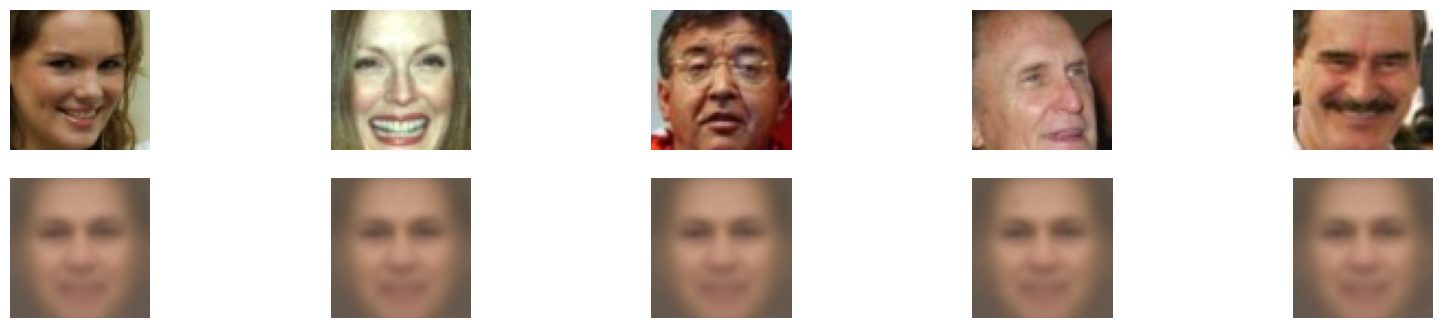

In [13]:
# Compare original and reconstructed images
import matplotlib.pyplot as plt
import numpy as np

n = 5
z_all = vae.encoder(x_test[:n])
z, _, _ = sample_latent(z_all)
decoded_imgs = vae.decoder(z)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.axis("off")
plt.show()